## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Федоров |
|---------|--------|
| Группа  | 7      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 15  9.9M   15 1535k    0     0  2799k      0  0:00:03 --:--:--  0:00:03 2801k
 48  9.9M   48 4914k    0     0  3178k      0  0:00:03  0:00:01  0:00:02 3177k
 82  9.9M   82 8322k    0     0  3267k      0  0:00:03  0:00:02  0:00:01 3267k
100  9.9M  100  9.9M    0     0  3275k      0  0:00:03  0:00:03 --:--:-- 3277k
"gzip" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


Теперь загружаем датасет:

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [4]:
data.shape

(42000, 784)

Посмотрим, что внутри

In [5]:
import matplotlib.pyplot as plt 
import pylab
from sklearn.datasets import make_classification

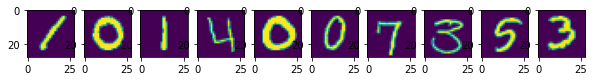

In [6]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(data[i].reshape(28,28))
pylab.show()

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    train_size=0.67, 
                                                    random_state=42)

# Фреймворк

## Линейный слой

In [9]:
class Linear:
    def __init__(self, nin, nout, learing_method):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.learing_method = learing_method
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T)+self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, lr):
        dW, db = self.learing_method.update(lr, self.dW, self.db)
        self.W += dW
        self.b += db

## Алгоритмы обучения линейных слоев

In [10]:
class GradientDescent:
    def __init__(self):
        pass
    
    def update(self, lr, dW, db):
        return (-lr * dW, -lr * db)
    
class NesterovAcceleratedGradient:
    def __init__(self, shape, beta = 0.9):
        self.beta = beta
        self.vdw = np.zeros(shape)
        self.vdb = np.zeros(shape[0])
        
    def update(self, lr, dw, db):
        self.vdw = self.beta*self.vdw+(1-self.beta)*dw
        self.vdb = self.beta*self.vdb+(1-self.beta)*db
        return (-lr * self.vdw, -lr * self.vdb)

class RMSprop:
    def __init__(self, shape, beta = 0.9):
        self.beta = beta
        self.vdw = np.zeros(shape)
        self.vdb = np.zeros(shape[0])
        
    def update(self, lr, dw, db):
        self.vdw = self.beta*self.vdw+(1-self.beta)*dw**2
        self.vdb = self.beta*self.vdb+(1-self.beta)*db**2
        return (-lr * self.vdw/(np.sqrt(self.vdw)+pow(10,-4)), -lr * self.vdb/(np.sqrt(self.vdb)+pow(10,-4)))

## SoftMax

In [11]:
class SoftMax:
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

## Передатоные функции Tanh, ReLU, Sigmoid, SoftSign

In [12]:
class Tanh:
    def forward(self, x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self, dy):
        return (1.0-self.y**2)*dy
    
class ReLU:
    def forward(self, x):
        self.y = np.maximum(x, np.zeros(x.shape))
        return self.y
    def backward(self, dy):
        z = self.y
        z[z > 0] = 1
        z *= dy
        return z
    
class Sigmoid:
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1 - self.y) * dy
    
class SoftSign:
    def forward(self, x):
        self.y = x/(1+np.absolute(x))
        return self.y
    
    def backward(self, dy):
        return 1/((1+np.absolute(x))**2) * dy

## Функции потерь CrossEntropyLoss, MeanSquareError, AbsoluteError

In [13]:
class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax/self.p
    
class MeanSquareError:
    def forward(self, p, y):
        self.p = p
        self.y = np.zeros_like(p)
        for i, j in enumerate(y):
            self.y[i, j] = 1
        return np.sum((self.y - self.p) ** 2)

    def backward(self, loss):
        return 2 * (self.p - self.y)
    
class AbsoluteError:
    def forward(self, p, y):
        self.p = p
        self.y = np.zeros_like(p)
        for i, j in enumerate(y):
            self.y[i, j] = 1
        return np.sum(np.absolute(self.y - self.p))

    def backward(self, loss):
        z = np.zeros_like(self.y)
        z[self.y - self.p > 0] = self.y - 1
        z[self.y - self.p < 0] = -self.y + 1
        return z

Описанные выше классы предназнаяены для сборки нейронной сети.

## Нейронная сеть

In [14]:
class Net:
    def __init__(self, loss_func):
        self.layers = []
        self.loss_func = loss_func()
        
    def add(self, l):
        self.layers.append(l)
    
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def forward_loss_func(self, p, y):
        return self.loss_func.forward(p, y)
    
    def backward_loss_func(self, loss):
        return self.loss_func.backward(loss)
    
    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
    
    def train_epoch(self, train_x, train_labels, batch_size = 4, lr = 0.1):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_labels[i:i+batch_size]

            p = self.forward(xb)
            l = self.loss_func.forward(p, yb)
            
            dp = self.loss_func.backward(l)
            dx = self.backward(dp)
            
            net.update(lr)
            
    def fit(self, train_x, train_labels, epoch_num = 1, batch_size = 4, lr = 0.1):
        for i in range(epoch_num):
            self.train_epoch(train_x, train_labels, batch_size, lr)
        
    def get_loss_acc(self, x, y):
        p = net.forward(x)
        l = loss.forward(p, y)
        pred = np.argmax(p, axis = 1)
        acc = (pred == y).mean()
        return l, acc
        
    def fit_and_plot(self, train_x, train_labels, test_x, test_labels, epoch_num = 1, batch_size = 4, lr = 0.1):
        accuracy = [[], []]
        loss = [[], []]
        for i in range(epoch_num):
            train_loss, train_acc = self.get_loss_acc(train_x, train_labels)
            test_loss, test_acc = self.get_loss_acc(test_x, test_labels)
            
            accuracy[0].append(train_acc)
            accuracy[1].append(test_acc)
            
            loss[0].append(train_loss)
            loss[1].append(test_loss)
            
            self.train_epoch(train_x, train_labels, batch_size, lr)
            
        figure = plt.figure(figsize = (15, 5))
        axes = figure.add_subplot(121)
        plt.title("accuracy")
        plt.plot(accuracy[0], label="train acc")
        plt.plot(accuracy[1], label="test acc")
        plt.legend(loc="upper left")
        
        axes = figure.add_subplot(122)
        plt.title("loss")
        plt.plot(loss[0], label="train loss")
        plt.plot(loss[1], label="test loss")
        plt.legend(loc="upper left")
        plt.show()
            
    def draw_confusion_matrix_and_graphics(self, x, y, n = 10):
        p = self.forward(x)
        predictions = np.argmax(p, axis = 1)
        confusion_matrix = []
        for i in range(n):
            confusion_matrix.append([0]*n)
            
        for i in range(len(predictions)):
            confusion_matrix[predictions[i]][y[i]] += 1
            
        figure = plt.figure(figsize = (10, 10))
        caxes = plt.matshow(confusion_matrix)
        plt.show()

Имеется встроенный функционал для посчета точности и постоения графиков функций потерь. Сама функция потерь встроена в класс, так как подразумеватеся, что ее подсечет будет происходить в поледний момент.

# Однослойная нейронная сеть

Опишу однослойную нейроннуб сеть для классификации MNIST. Сделаю 10 эпох с learning rate = 0.000001. Большие learning rate (начиная с 0.0001 и выше приводит к большим весам и порождают NaN-ы из-за очень маленьких выходных вероятностей)

Initial loss=123.01972992837452, accuracy=0.06691542288557215 


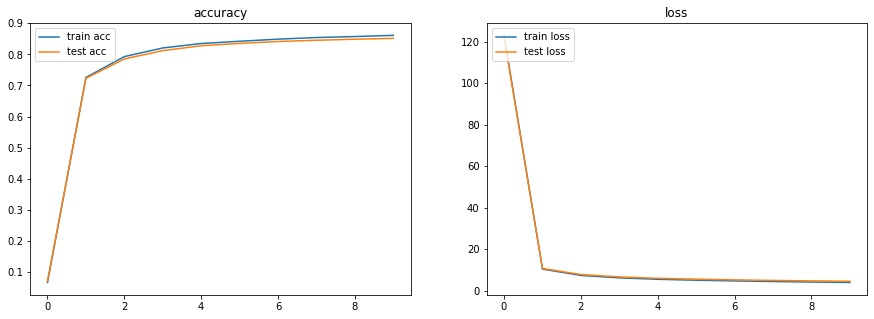

Final loss=3.7792449653993443, accuracy=0.8647832267235253 
Test loss=4.3688116876500205, accuracy=0.8541847041847042 


In [15]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 10, GradientDescent()))
net.add(SoftMax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 10, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))

Отлично, вероятность правильного ответа на валидационной выборке больше 85%. Взглянем на матрицу ошибок.

<Figure size 720x720 with 0 Axes>

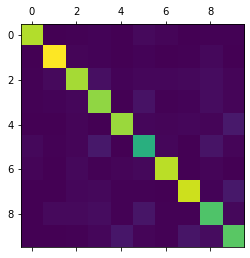

In [16]:
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Диагональ видна ясно. Хорошо.

## Многослоная модель

Попробую трехслойную нейронную сеть. В качесвте передаточной функции везде использую функцию ReLU, так как она хороша для обучения по картинкам. На внутренних слоях установлю 100 нейронов. Обучение также буду производить в 30 эпох с learning rate = 0.000001

Initial loss=80.65821436893181, accuracy=0.08862828713574983 


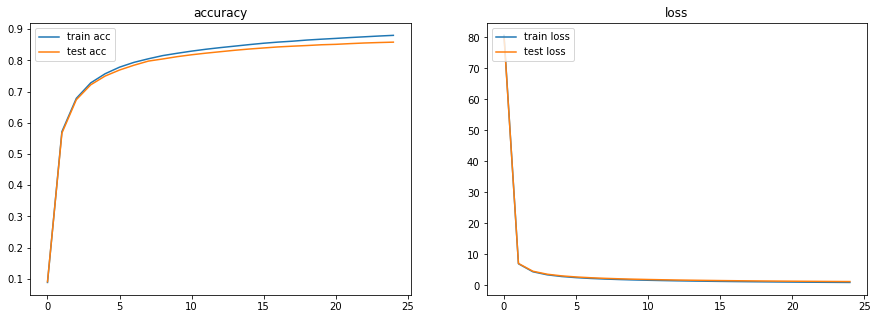

Final loss=0.9318185187873786, accuracy=0.8819474058280028 
Test loss=1.2182200075584941, accuracy=0.8602453102453103 


In [17]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))

Точность 86%. Снова посмотрим на матрицу ошибок.

<Figure size 720x720 with 0 Axes>

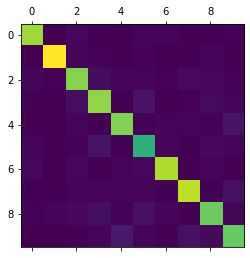

In [18]:
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

# Сравнение с различными гиперпараметрами

Буду отталкиваться от многослойной модели выше.

## Другие передаточные функции

Попробуем гиперболический тангенс и сигмойду.

Tanh usage:
Initial loss=2.5106630371484897, accuracy=0.10796019900497512 


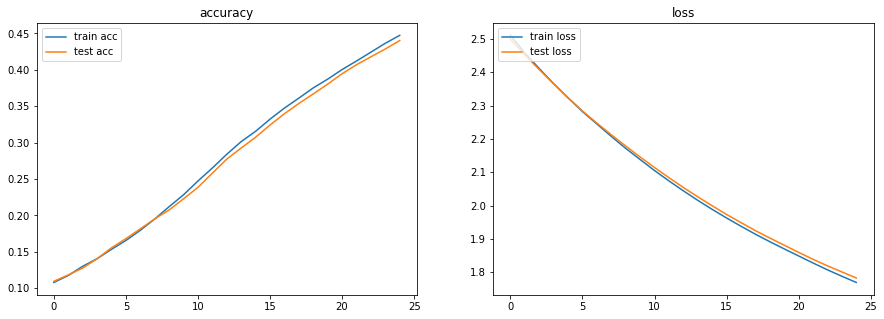

Final loss=1.7510502987305514, accuracy=0.4567874911158493 
Test loss=1.7647852630341256, accuracy=0.4476911976911977 


<Figure size 720x720 with 0 Axes>

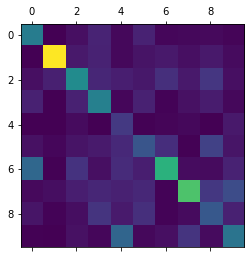

---------------------------------------------
Sigmoid usage:
Initial loss=2.420512664994967, accuracy=0.09633972992181948 


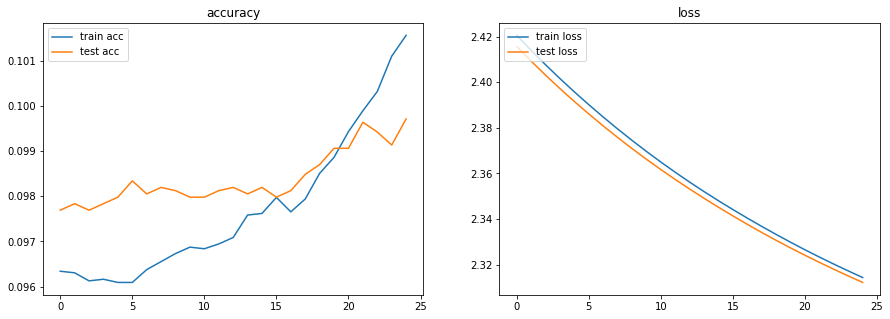

Final loss=2.3115289672402635, accuracy=0.10174129353233831 
Test loss=2.3094514861254236, accuracy=0.10036075036075036 


<Figure size 720x720 with 0 Axes>

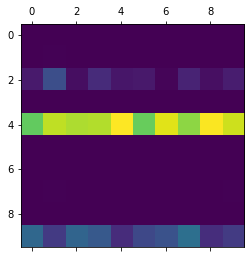

In [19]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(Tanh())
net.add(Linear(100, 100, GradientDescent()))
net.add(Tanh())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("Tanh usage:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(Sigmoid())
net.add(Linear(100, 100, GradientDescent()))
net.add(Sigmoid())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("---------------------------------------------")
print("Sigmoid usage:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Результаты сильно хуже того, что было изначально, хотя ссудя по графикам обучение идет.

## Другое число нейронов

Кажется, что чем больше неронов, тем лучше. Но чем больше количество, тем дольше модель будет обучаться. Попробуем 10, 25, 50, 150 нейронов в промежуточном слое.

---------------------------------------------
10 neurons:
Initial loss=73.82746236475249, accuracy=0.07107320540156362 


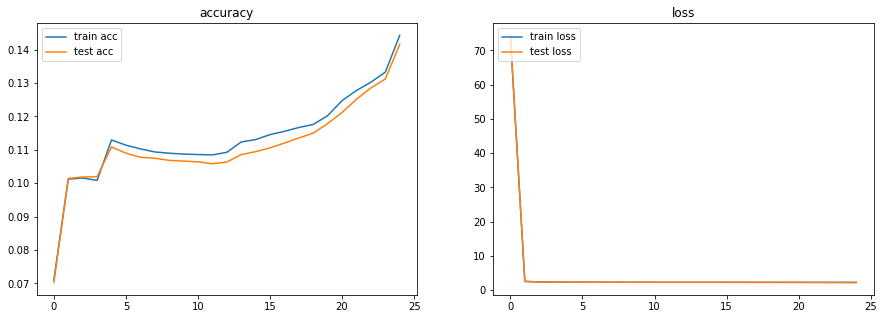

Final loss=2.263614251604186, accuracy=0.1490049751243781 
Test loss=2.2623947277660665, accuracy=0.1466089466089466 


<Figure size 720x720 with 0 Axes>

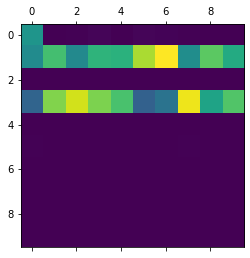

---------------------------------------------
25 neurons:
Initial loss=75.2755537184159, accuracy=0.13745557924662402 


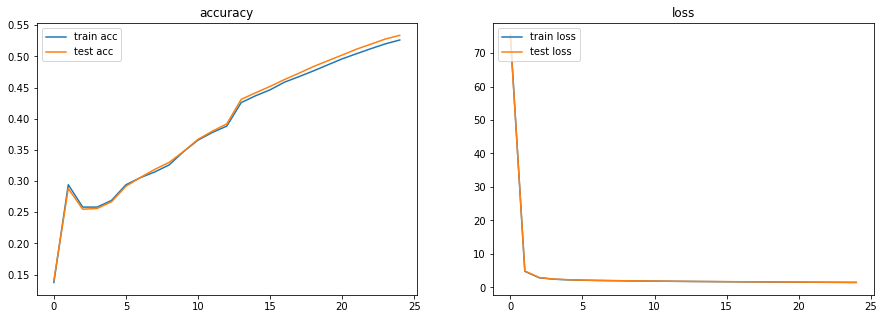

Final loss=1.4719180626143105, accuracy=0.5334044065387349 
Test loss=1.4948154872370887, accuracy=0.5411255411255411 


<Figure size 720x720 with 0 Axes>

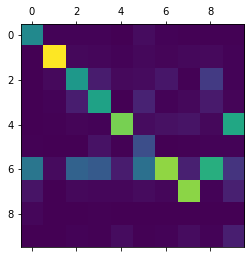

---------------------------------------------
50 neurons:
Initial loss=47.76461763767298, accuracy=0.0912224591329069 


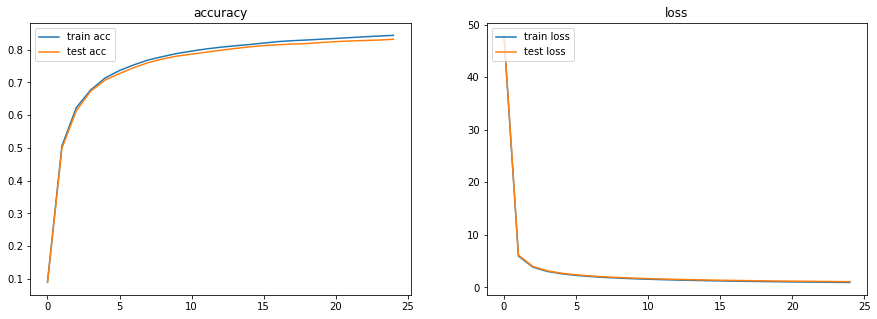

Final loss=0.9087917298107516, accuracy=0.8450604122245914 
Test loss=1.0588026643268629, accuracy=0.833044733044733 


<Figure size 720x720 with 0 Axes>

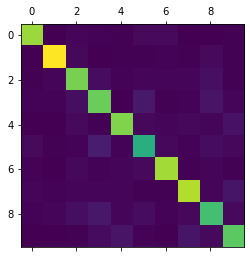

---------------------------------------------
150 neurons:
Initial loss=57.08594614896553, accuracy=0.07587064676616916 


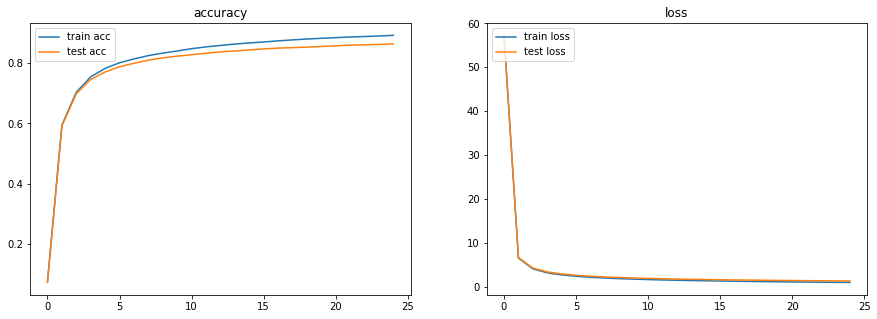

Final loss=0.908461511350099, accuracy=0.8941009239516702 
Test loss=1.2455669330895556, accuracy=0.8649350649350649 


<Figure size 720x720 with 0 Axes>

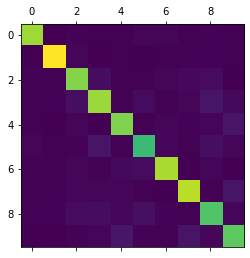

In [20]:
neuron_nums = [10, 25, 50, 150]

for neuron_num in neuron_nums:
    net = Net(CrossEntropyLoss)
    net.add(Linear(784, neuron_num, GradientDescent()))
    net.add(ReLU())
    net.add(Linear(neuron_num, neuron_num, GradientDescent()))
    net.add(ReLU())
    net.add(Linear(neuron_num, 10, GradientDescent()))
    net.add(SoftMax())

    print("---------------------------------------------")
    print(neuron_num, "neurons:")
    print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

    net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

    print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
    print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
    net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Как и ожидалось, точность растет с ростом числа нейронов. Однако разница между сотней нейронов и ста пятьюдесятью невелика. Наводит на мысли о целесообразности дальнейшего наращивания.

## Другие функции потерь

Попробую MeanSquareError и AbsoluteError. Но кажется, что AbsoluteError будет сходиться дольше.

MSE usage:
Initial loss=73.06397316676978, accuracy=0.09946695095948828 


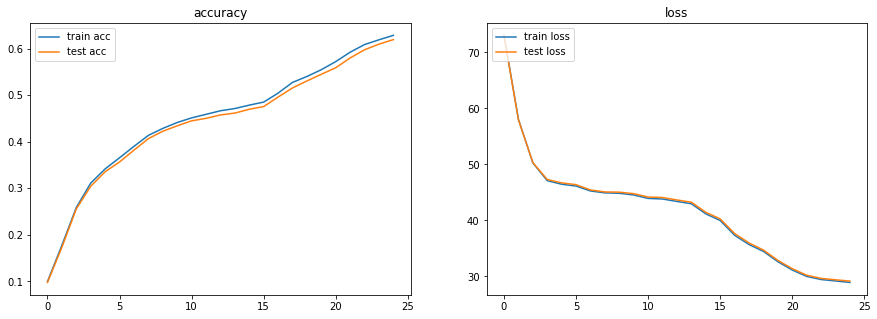

Final loss=28.70395458428099, accuracy=0.6367803837953092 
Test loss=28.951454086792968, accuracy=0.6254689754689755 


<Figure size 720x720 with 0 Axes>

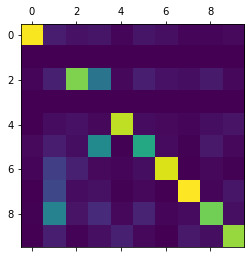

---------------------------------------------
AbsoluteError usage:
Initial loss=55.92895184121948, accuracy=0.11691542288557213 


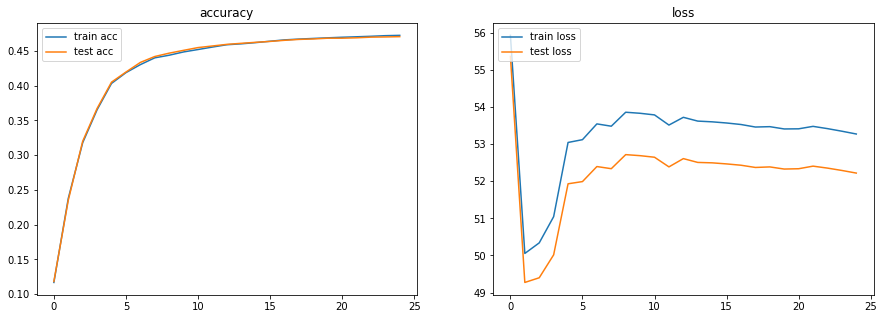

Final loss=53.208412539556, accuracy=0.4727078891257996 
Test loss=52.159771003140655, accuracy=0.47063492063492063 


<Figure size 720x720 with 0 Axes>

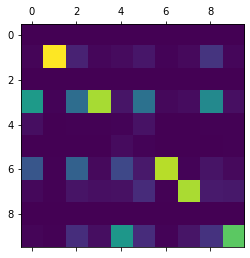

In [21]:
net = Net(MeanSquareError)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("MSE usage:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

net = Net(MeanSquareError)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("---------------------------------------------")
print("AbsoluteError usage:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Из графиков видно, что обучение идет и результаты улучшаются, но гораздо медленее, чем с кросс энтропией. Изначальный варинат снова оказался лучшим.

## Другое количество слоев

Кажется, что увеличчение количества слоев может улучшить результат. Но, как с увеличением числа нейронов, время обучения возрастет. Попробую количество слоев 2, 4, 5.

two layers:
Initial loss=90.0160516425611, accuracy=0.1316275764036958 


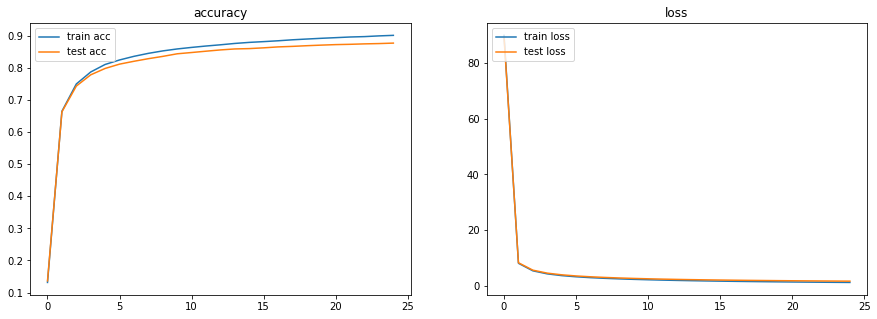

Final loss=1.1557516201996505, accuracy=0.9027718550106609 
Test loss=1.6195002925930346, accuracy=0.8776334776334777 


<Figure size 720x720 with 0 Axes>

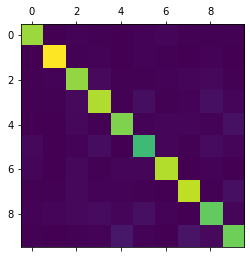

---------------------------------------------
four layers:
Initial loss=60.96548986949943, accuracy=0.05159914712153518 


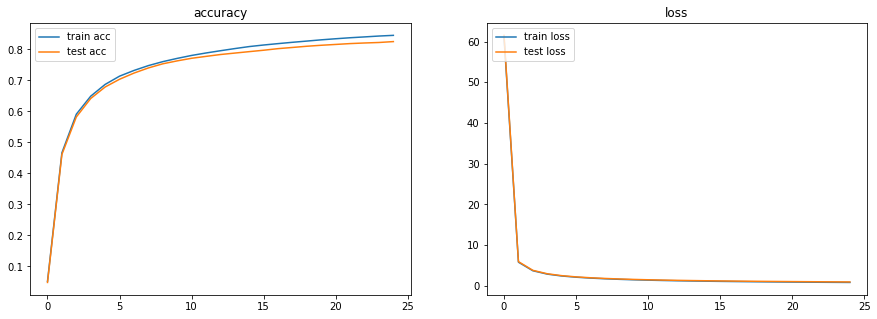

Final loss=0.7784879083742536, accuracy=0.8481876332622601 
Test loss=0.9035546031090264, accuracy=0.8275613275613276 


<Figure size 720x720 with 0 Axes>

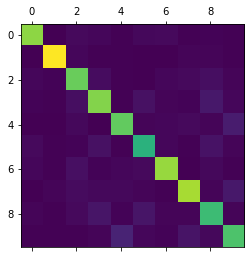

---------------------------------------------
five layers:
Initial loss=40.69940815601479, accuracy=0.09644633972992182 


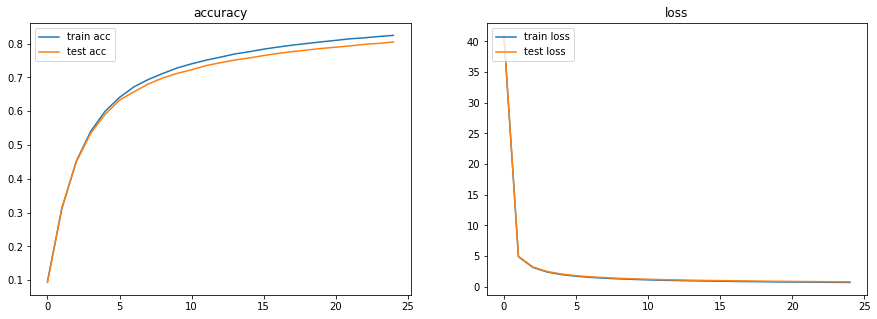

Final loss=0.6769527842390979, accuracy=0.8272210376687988 
Test loss=0.7747920807885549, accuracy=0.807070707070707 


<Figure size 720x720 with 0 Axes>

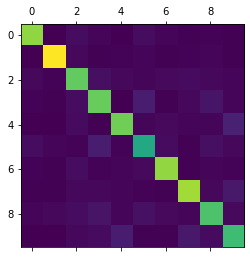

In [22]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("two layers:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("---------------------------------------------")
print("four layers:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("---------------------------------------------")
print("five layers:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Интересный результат. С ростом слоев падает качество. Но по графикам не видно, что модель переобучилась. Видимо имеет место быть недообучение.

## Другие модели обучения

Попробуем Nesterov Accelerated Gradient и Среднеквадратичное распространение.

Nesterov Accelerated Gradient:
Initial loss=52.54129411524013, accuracy=0.07896233120113717 


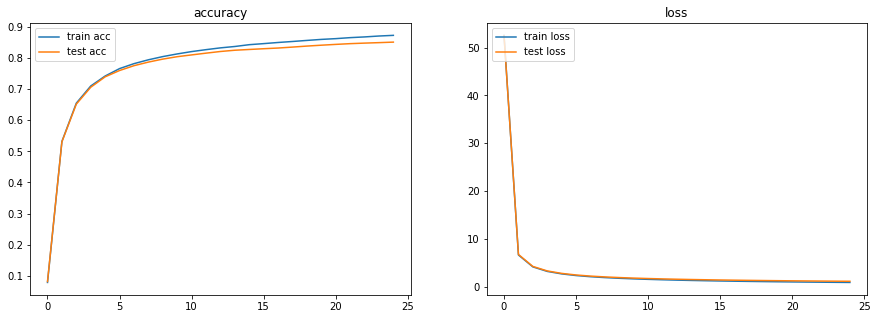

Final loss=0.8931206915087276, accuracy=0.8749111584932481 
Test loss=1.1370329641180998, accuracy=0.8527417027417027 


<Figure size 720x720 with 0 Axes>

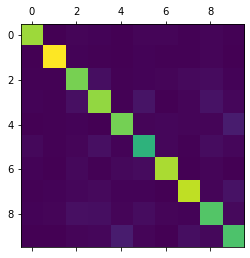

---------------------------------------------
RMSprop:
Initial loss=69.59498864829499, accuracy=0.0796730632551528 


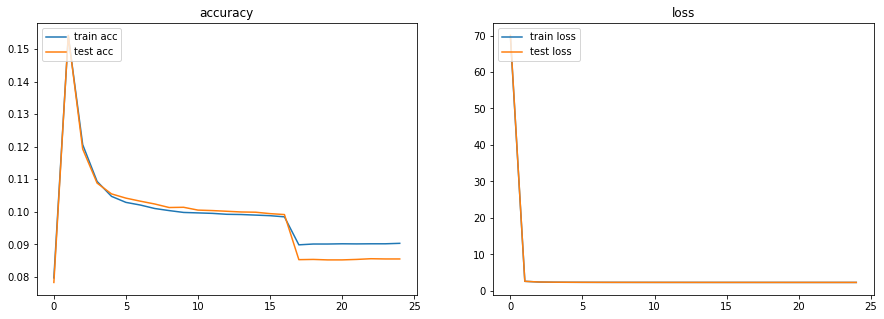

Final loss=2.305515379289575, accuracy=0.09047619047619047 
Test loss=2.3145187265734233, accuracy=0.0854978354978355 


<Figure size 720x720 with 0 Axes>

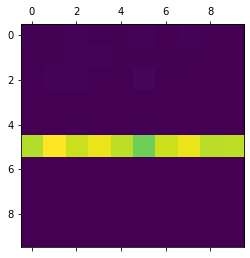

In [23]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, NesterovAcceleratedGradient(shape = (100, 784))))
net.add(ReLU())
net.add(Linear(100, 100, NesterovAcceleratedGradient(shape = (100, 100))))
net.add(ReLU())
net.add(Linear(100, 10, NesterovAcceleratedGradient(shape = (10, 100))))
net.add(SoftMax())

print("Nesterov Accelerated Gradient:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, RMSprop(shape = (100, 784))))
net.add(ReLU())
net.add(Linear(100, 100, RMSprop(shape = (100, 100))))
net.add(ReLU())
net.add(Linear(100, 10, RMSprop(shape = (10, 100))))
net.add(SoftMax())

print("---------------------------------------------")
print("RMSprop:")
print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Nesterov Accelerated Gradient дал хороший результат. Среднеквадратичное распространение же наоборот, хоть функция потерь и упала , но результат неудовлетворителен.

## Улучшение результата

Попробую использовать удачные идеи и учлушить качество предсказаний. Также снижу learning rate вдвое и увеличу количетсво эпох.

Initial loss=72.17290233484024, accuracy=0.07338308457711443 


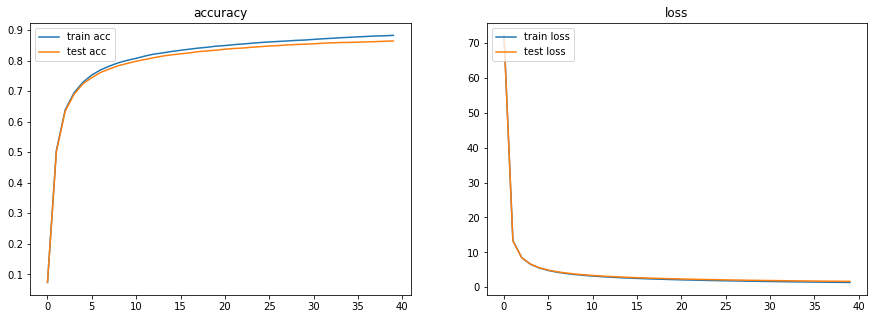

Final loss=1.356068939360523, accuracy=0.8839019189765458 
Test loss=1.6655146076892353, accuracy=0.866017316017316 


<Figure size 720x720 with 0 Axes>

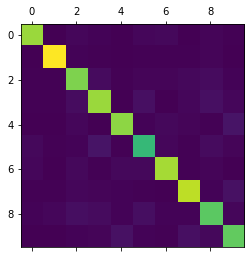

In [24]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, NesterovAcceleratedGradient(shape = (100, 784))))
net.add(ReLU())
net.add(Linear(100, 10, NesterovAcceleratedGradient(shape = (10, 100))))
net.add(SoftMax())

print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))

net.fit_and_plot(X_train, y_train, X_test, y_test, 40, 4, 0.0000005)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(X_train, y_train)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(X_test, y_test)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Результат стал лучше но не сильно.

# FashionMNIST

Загружу данные

In [25]:
!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

import gzip
with gzip.open("test-labels.gz", "rb") as gz:
    test_y = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    test_X = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(test_y), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    train_y = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    train_X = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(train_y), 784)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4318k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 46 4318k   46 2028k    0     0  1487k      0  0:00:02  0:00:01  0:00:01 1487k
100 4318k  100 4318k    0     0  1887k      0  0:00:02  0:00:02 --:--:-- 1888k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5148  100  5148    0     0  20053      0 --:--:-- --:--:-- --:--:-- 20031
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   

Посмотрим, что внутри.

In [26]:
train_X.shape

(60000, 784)

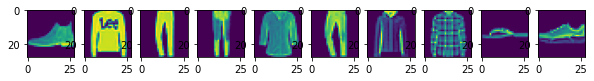

In [27]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(test_X[i].reshape(28,28))
pylab.show()

Initial loss=135.97756847415317, accuracy=0.11086666666666667 


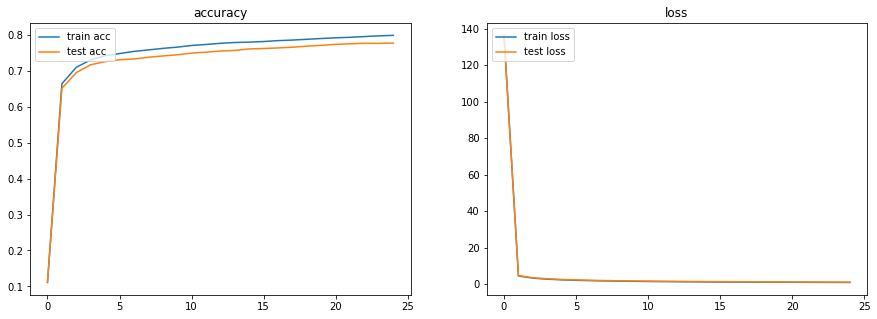

Final loss=0.8444844614099073, accuracy=0.8005166666666667 
Test loss=1.0047295709875133, accuracy=0.7788 


<Figure size 720x720 with 0 Axes>

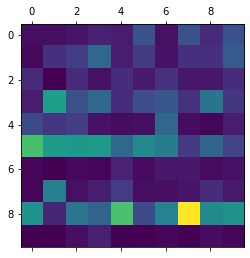

In [28]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 100, GradientDescent()))
net.add(ReLU())
net.add(Linear(100, 10, GradientDescent()))
net.add(SoftMax())

print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(train_X, train_y)))

net.fit_and_plot(train_X, train_y, test_X, test_y, 25, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(train_X, train_y)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(test_X, test_y)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Хоть результат хуже, чем на цифрах, но все равно неплохо. Попробую увеличить число нейронов.

Initial loss=49.65706899466024, accuracy=0.06663333333333334 


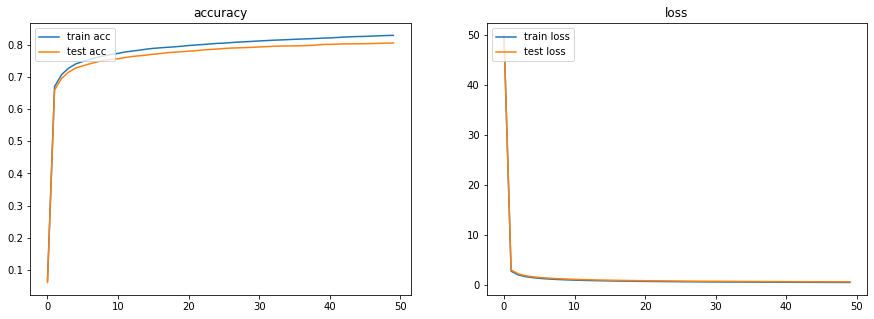

Final loss=0.535138658061432, accuracy=0.8295666666666667 
Test loss=0.6583955901537196, accuracy=0.8062 


<Figure size 720x720 with 0 Axes>

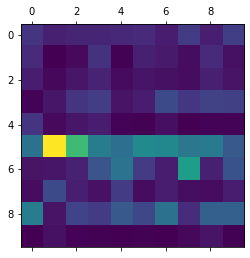

In [29]:
net = Net(CrossEntropyLoss)
net.add(Linear(784, 150, GradientDescent()))
net.add(ReLU())
net.add(Linear(150, 150, GradientDescent()))
net.add(ReLU())
net.add(Linear(150, 150, GradientDescent()))
net.add(ReLU())
net.add(Linear(150, 10, GradientDescent()))
net.add(SoftMax())

print("Initial loss={}, accuracy={} ".format(*net.get_loss_acc(train_X, train_y)))

net.fit_and_plot(train_X, train_y, test_X, test_y, 50, 4, 0.000001)

print("Final loss={}, accuracy={} ".format(*net.get_loss_acc(train_X, train_y)))
print("Test loss={}, accuracy={} ".format(*net.get_loss_acc(test_X, test_y)))
net.draw_confusion_matrix_and_graphics(X_test, y_test, 10)

Точность повысилась до 80%. Хорошо.